In [1]:
from skimage import io
from skimage.transform import rescale
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
from LM_data_mgmt import DAO
import tensorflow as tf
from HLM_data_utils import pnt_on_grid, quant_rot, list_from_fingerprint, get_pos_from_list_fp, list_from_rotation, get_rot_from_slice
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
from tensorflow.keras import layers, models, losses


1 Physical GPUs, 1 Logical GPUs


2022-08-31 14:08:55.104516: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 14:08:55.134767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 14:08:55.135340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 14:08:55.137307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 14:08:55.137565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [2]:
map_img = io.imread("data/ait_office.png")

with open("data/datasetaitoff_path720.csv", "r") as data:
    laser_db = pd.read_csv(data, delimiter=";").copy()

Model definition

In [3]:
#coda separata (pos, rot)
def model_define(map_img, laser, training=True):

    map_input = layers.Input(map_img.shape)
    
    map_branch = layers.Conv2D(8, (11,11), padding="valid", name="map_conv_1")(map_input)
    map_branch = layers.Conv2D(16, (7,7), padding="valid", name="map_conv_2")(map_branch)
    map_branch = layers.MaxPool2D((5,5), strides=2, padding="valid", name="map_pooling_1")(map_branch)
    map_branch = layers.BatchNormalization(name="map_norm_1")(map_branch)
    map_branch = layers.Conv2D(32, (7,7), padding="valid", name="map_conv_3")(map_branch)
    map_branch = layers.MaxPool2D((5,5), strides=2, padding="valid", name="map_pooling_2")(map_branch)
    map_branch = layers.BatchNormalization(name="map_norm_2")(map_branch)
    map_branch = layers.Conv2D(64, (5,5), padding="valid", name="map_conv_4")(map_branch)
    map_branch = layers.MaxPool2D((3,3), strides=2, padding="valid", name="map_pooling_3")(map_branch)
    map_branch = layers.BatchNormalization(name="map_norm_3")(map_branch)
    map_branch = layers.Conv2D(64, (5,5), padding="valid", name="map_conv_5")(map_branch)
    map_branch = layers.MaxPool2D((3,3), strides=2, padding="valid", name="map_pooling_4")(map_branch)
    map_branch = layers.BatchNormalization(name="map_norm_4")(map_branch)

    map_branch = layers.Flatten()(map_branch)
 
    laser_input = layers.Input(laser.shape)

    laser_branch = layers.Conv1D(16, 11, padding="same", activation="relu", name="laser_conv_1")(laser_input)
    laser_branch = layers.Conv1D(32, 5, padding="same", activation="relu", name="laser_conv_2")(laser_branch)
    laser_branch = layers.MaxPool1D(2, strides=2, padding="same", name="laser_pool_1" )(laser_branch)
    laser_branch = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu", name="laser_conv_3" )(laser_branch)
    laser_branch = layers.MaxPool1D(2, strides=2, padding="same", name="laser_pool_2" )(laser_branch)
    laser_branch = layers.Conv1D(256, kernel_size=5, padding="same", activation="relu", name="laser_conv_4" )(laser_branch)
    laser_branch = layers.MaxPool1D(2, strides=2, padding="same", name="laser_pool_3" )(laser_branch)


    laser_branch = layers.Flatten()(laser_branch)
    
    merged_branch = layers.Concatenate()([map_branch,laser_branch])

    if training:
        merged_branch = layers.Dropout(0.3)(merged_branch)

    merged_branch_pos = layers.Dense(1024, activation="relu", name="fc_merged_pos_1")(merged_branch)
    merged_branch_pos = layers.Dense(256, activation="relu", name="fc_merged_pos_2")(merged_branch_pos)
    merged_branch_pos = layers.Dense(2, name="fc_pos_out")(merged_branch_pos)
    
    merged_branch_rot = layers.Dense(64, activation="relu", name="fc_merged_rot")(merged_branch)
    merged_branch_rot = layers.Dense(1, name="fc_rot_out")(merged_branch_rot)
    
    return models.Model([map_input,laser_input],[merged_branch_pos, merged_branch_rot])#merged_branch_pos)

beta = 0.2

def loss_fn(y_true, y_pred):
    pos_loss = tf.multiply(losses.MeanSquaredError()(y_true[0], y_pred[0]),1-beta)
    rot_loss = tf.multiply(losses.MeanAbsoluteError()(y_true[1], y_pred[1]), beta)

    return layers.Add()([pos_loss, rot_loss])

In [3]:
#coda separata (map_mask, rot_mask)
def model_define(map_img, laser, rot_dim=0, training=True):

    map_input = layers.Input(map_img.shape)
    
    map_branch_1 = layers.Conv2D(8, 11, padding="same", activation="relu", name="map_conv_1")(map_input)
    map_branch_2 = layers.Conv2D(16, 7, padding="same", activation="relu", name="map_conv_2")(map_branch_1)
    map_branch_3 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_1")(map_branch_2)
    map_branch_3 = layers.BatchNormalization()(map_branch_3)
    
    if training:
        map_branch_3 = layers.Dropout(0.3)(map_branch_3)
    else:
        map_branch_3 = layers.Dropout(0.0)(map_branch_3)

    map_branch_5 = layers.Conv2D(32, 7, padding="same", activation="relu", name="map_conv_3")(map_branch_3)
    map_branch_6 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_2")(map_branch_5)
    map_branch_6 = layers.BatchNormalization()(map_branch_6)
    
    if training:
        map_branch_6 = layers.Dropout(0.3)(map_branch_6)
    else:
        map_branch_6 = layers.Dropout(0.0)(map_branch_6)
    map_branch_8 = layers.Conv2D(64, 5, padding="same", activation="relu", name="map_conv_4")(map_branch_6)
    map_branch_9 = layers.MaxPool2D(3, strides=2, padding="same", name="map_pooling_3")(map_branch_8)
    map_branch_9 = layers.BatchNormalization()(map_branch_9)
    
    if training:
        map_branch_9 = layers.Dropout(0.3)(map_branch_9)
    else:
        map_branch_9 = layers.Dropout(0.0)(map_branch_9)
    map_branch_11 = layers.Conv2D(128, 5, padding="same", activation="relu", name="map_conv_5")(map_branch_9)
    map_branch_12 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_4")(map_branch_11)
    map_branch_12 = layers.BatchNormalization()(map_branch_12)
    
    if training:
        map_branch_12 = layers.Dropout(0.3)(map_branch_12)
    else:
        map_branch_12 = layers.Dropout(0.0)(map_branch_12)

    laser_input = layers.Input(laser.shape)

    laser_branch = layers.Conv1D(32, 11, padding="valid", activation="relu", name="laser_conv_1")(laser_input)
    laser_branch = layers.Conv1D(64, 7, padding="valid", activation="relu", name="laser_conv_2")(laser_branch)
    laser_branch = layers.MaxPool1D(5, strides=3, padding="same", name="laser_pool_1" )(laser_branch)
    laser_branch = layers.BatchNormalization()(laser_branch)
    
    if training:
        laser_branch = layers.Dropout(0.3)(laser_branch)
    else:
        laser_branch = layers.Dropout(0.0)(laser_branch)
    laser_branch = layers.Conv1D(128, kernel_size=5, padding="valid", activation="relu", name="laser_conv_3" )(laser_branch)
    laser_branch = layers.MaxPool1D(3, strides=2, padding="same", name="laser_pool_2" )(laser_branch)
    laser_branch = layers.BatchNormalization()(laser_branch)
    
    if training:
        laser_branch = layers.Dropout(0.3)(laser_branch)
    else:
        laser_branch = layers.Dropout(0.0)(laser_branch)
    laser_branch = layers.Conv1D(256, kernel_size=5, padding="valid", activation="relu", name="laser_conv_4" )(laser_branch)
    laser_branch = layers.MaxPool1D(3, strides=2, padding="same", name="laser_pool_3" )(laser_branch)

    laser_branch = layers.BatchNormalization()(laser_branch)
    
    if training:
        laser_branch = layers.Dropout(0.3)(laser_branch)
    else:
        laser_branch = layers.Dropout(0.0)(laser_branch)

    laser_branch = layers.Flatten()(laser_branch)
    
    #merged_branch = layers.Concatenate()([map_branch_flat,laser_branch])

    if training:
        laser_branch = layers.Dropout(0.3)(laser_branch)

    #in_model = models.Model([map_input,laser_input],merged_branch)

    #in_model.trainable = training

    laser_branch = layers.Dense((map_branch_12.shape[1]*map_branch_12.shape[2]*64), activation="relu", name="fc_merged")(laser_branch)
    laser_branch_reshape = layers.Reshape((map_branch_12.shape[1],map_branch_12.shape[2],64))(laser_branch)

    merged_branch_pos = layers.Concatenate()([map_branch_12,laser_branch_reshape])

    merged_branch_pos_1 = layers.Conv2DTranspose(32,5,3, padding="same")(merged_branch_pos)

    #position branch
    
    diff_width = int(merged_branch_pos_1.shape[1] - map_branch_11.shape[1] + 1)
    diff_heigth = int(merged_branch_pos_1.shape[2] - map_branch_11.shape[2] + 1)

    padded = False

    if (diff_width > 1) or (diff_heigth > 1):
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(32,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos_1)

    else:
        merged_branch_pos = layers.Conv2D(32,7,activation="relu", padding="same")(merged_branch_pos_1)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    if training:
        merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_11])
   
    merged_branch_pos = layers.Conv2DTranspose(32,5,2, padding="same")(merged_branch_pos) 

    if training:
       merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)

    diff_width = int(merged_branch_pos.shape[1] - map_branch_8.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_8.shape[2] + 1)

    padded = False

    if (diff_width > 1) or (diff_heigth > 1):
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(16,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(16,5,activation="relu", padding="same")(merged_branch_pos)

    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    if training:
        merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_8])

    merged_branch_pos = layers.Conv2DTranspose(16,7,3, padding="same")(merged_branch_pos) 
    
    if training:
        merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)

    diff_width = int(merged_branch_pos.shape[1] - map_branch_5.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_5.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(8,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(8,7,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    if training:
        merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_5])

    merged_branch_pos = layers.Conv2DTranspose(8,7,3, padding="same")(merged_branch_pos) 

    diff_width = int(merged_branch_pos.shape[1] - map_branch_2.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_2.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(4,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(4,7,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.BatchNormalization()(merged_branch_pos)

    if training:
        merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)
    else:
        merged_branch_pos = layers.Dropout(0.0)(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_2])

    merged_branch_pos = layers.Conv2DTranspose(2,11, padding="same", name="pos_output")(merged_branch_pos) 

    #rotation branch

    merged_branch_rot = layers.Conv2D(64,(merged_branch_pos_1.shape[1],1), activation="relu", padding="valid")(merged_branch_pos_1)

    if training:
        merged_branch_rot = layers.Dropout(0.3)(merged_branch_rot)
    
    merged_branch_rot = layers.Reshape((merged_branch_pos_1.shape[2],64))(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(32,5,3, activation="relu")(merged_branch_rot)

    diff_width = int(merged_branch_rot.shape[1] - int(rot_dim/9) + 1)
    padded = False

    if diff_width > 1:
        padded = True

    if padded:
        merged_branch_rot = layers.Conv1D(16,(diff_width,),activation="relu", padding="valid")(merged_branch_rot)

    else:
        merged_branch_rot = layers.Conv1D(16,7,activation="relu", padding="same")(merged_branch_rot)

    merged_branch_rot = layers.BatchNormalization()(merged_branch_rot)

    if training:
        merged_branch_rot = layers.Dropout(0.3)(merged_branch_rot)
    else:
        merged_branch_rot = layers.Dropout(0.0)(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(16,5,3, activation="relu")(merged_branch_rot)

    if training:
        merged_branch_rot = layers.Dropout(0.3)(merged_branch_rot)

    diff_width = int(merged_branch_rot.shape[1] - int(rot_dim/3) + 1)
    padded = False

    if diff_width > 1:
        padded = True

    if padded:
        merged_branch_rot = layers.Conv1D(8,(diff_width,),activation="relu", padding="valid")(merged_branch_rot)

    else:
        merged_branch_rot = layers.Conv1D(8,7,activation="relu", padding="same")(merged_branch_rot)

    merged_branch_rot = layers.BatchNormalization()(merged_branch_rot)

    if training:
        merged_branch_rot = layers.Dropout(0.3)(merged_branch_rot)
    else:
        merged_branch_rot = layers.Dropout(0.0)(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(8,5,3, activation="relu")(merged_branch_rot)

    diff_width = int(merged_branch_rot.shape[1] - rot_dim + 1)
    padded = False

    if diff_width > 1:
        padded = True

    if padded:
        merged_branch_rot = layers.Conv1D(4,(diff_width,),activation="relu", padding="valid")(merged_branch_rot)

    else:
        merged_branch_rot = layers.Conv1D(4,7,activation="relu", padding="same")(merged_branch_rot)

    merged_branch_rot = layers.BatchNormalization()(merged_branch_rot)

    if training:
        merged_branch_rot = layers.Dropout(0.3)(merged_branch_rot)
    else:
        merged_branch_rot = layers.Dropout(0.0)(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(2, rot_dim, padding="same", name="rot_output")(merged_branch_rot)

    return models.Model([map_input,laser_input],[merged_branch_pos, merged_branch_rot])#merged_branch_pos)

beta = 0.2

def loss_pos_fn(y_true, y_pred):
    
    print("pos ",y_true)
    #print("rot ",y_true_rot)

    pos_loss = losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred)
    #rot_loss = losses.MeanAbsoluteError()(y_true, y_pred)

    return pos_loss


In [4]:
laser_inst=[]

for i in laser_db.values:
    if i[0] == 1:
        laser_inst.append(i[3])

laser_inst = tf.reshape(laser_inst, [720,1])

max_pixel = 10000
pixel_scale = 0.05
tot_pixel = map_img.shape[0]*map_img.shape[1]

if tot_pixel > max_pixel:
    rate_rescale = np.sqrt(max_pixel/tot_pixel)
    map_img = rescale(map_img,rate_rescale)
    pixel_scale = pixel_scale/rate_rescale

map_img_tensor = tf.reshape(map_img, [map_img.shape[0],map_img.shape[1],1])


In [5]:
model = model_define(map_img_tensor, laser_inst,90)

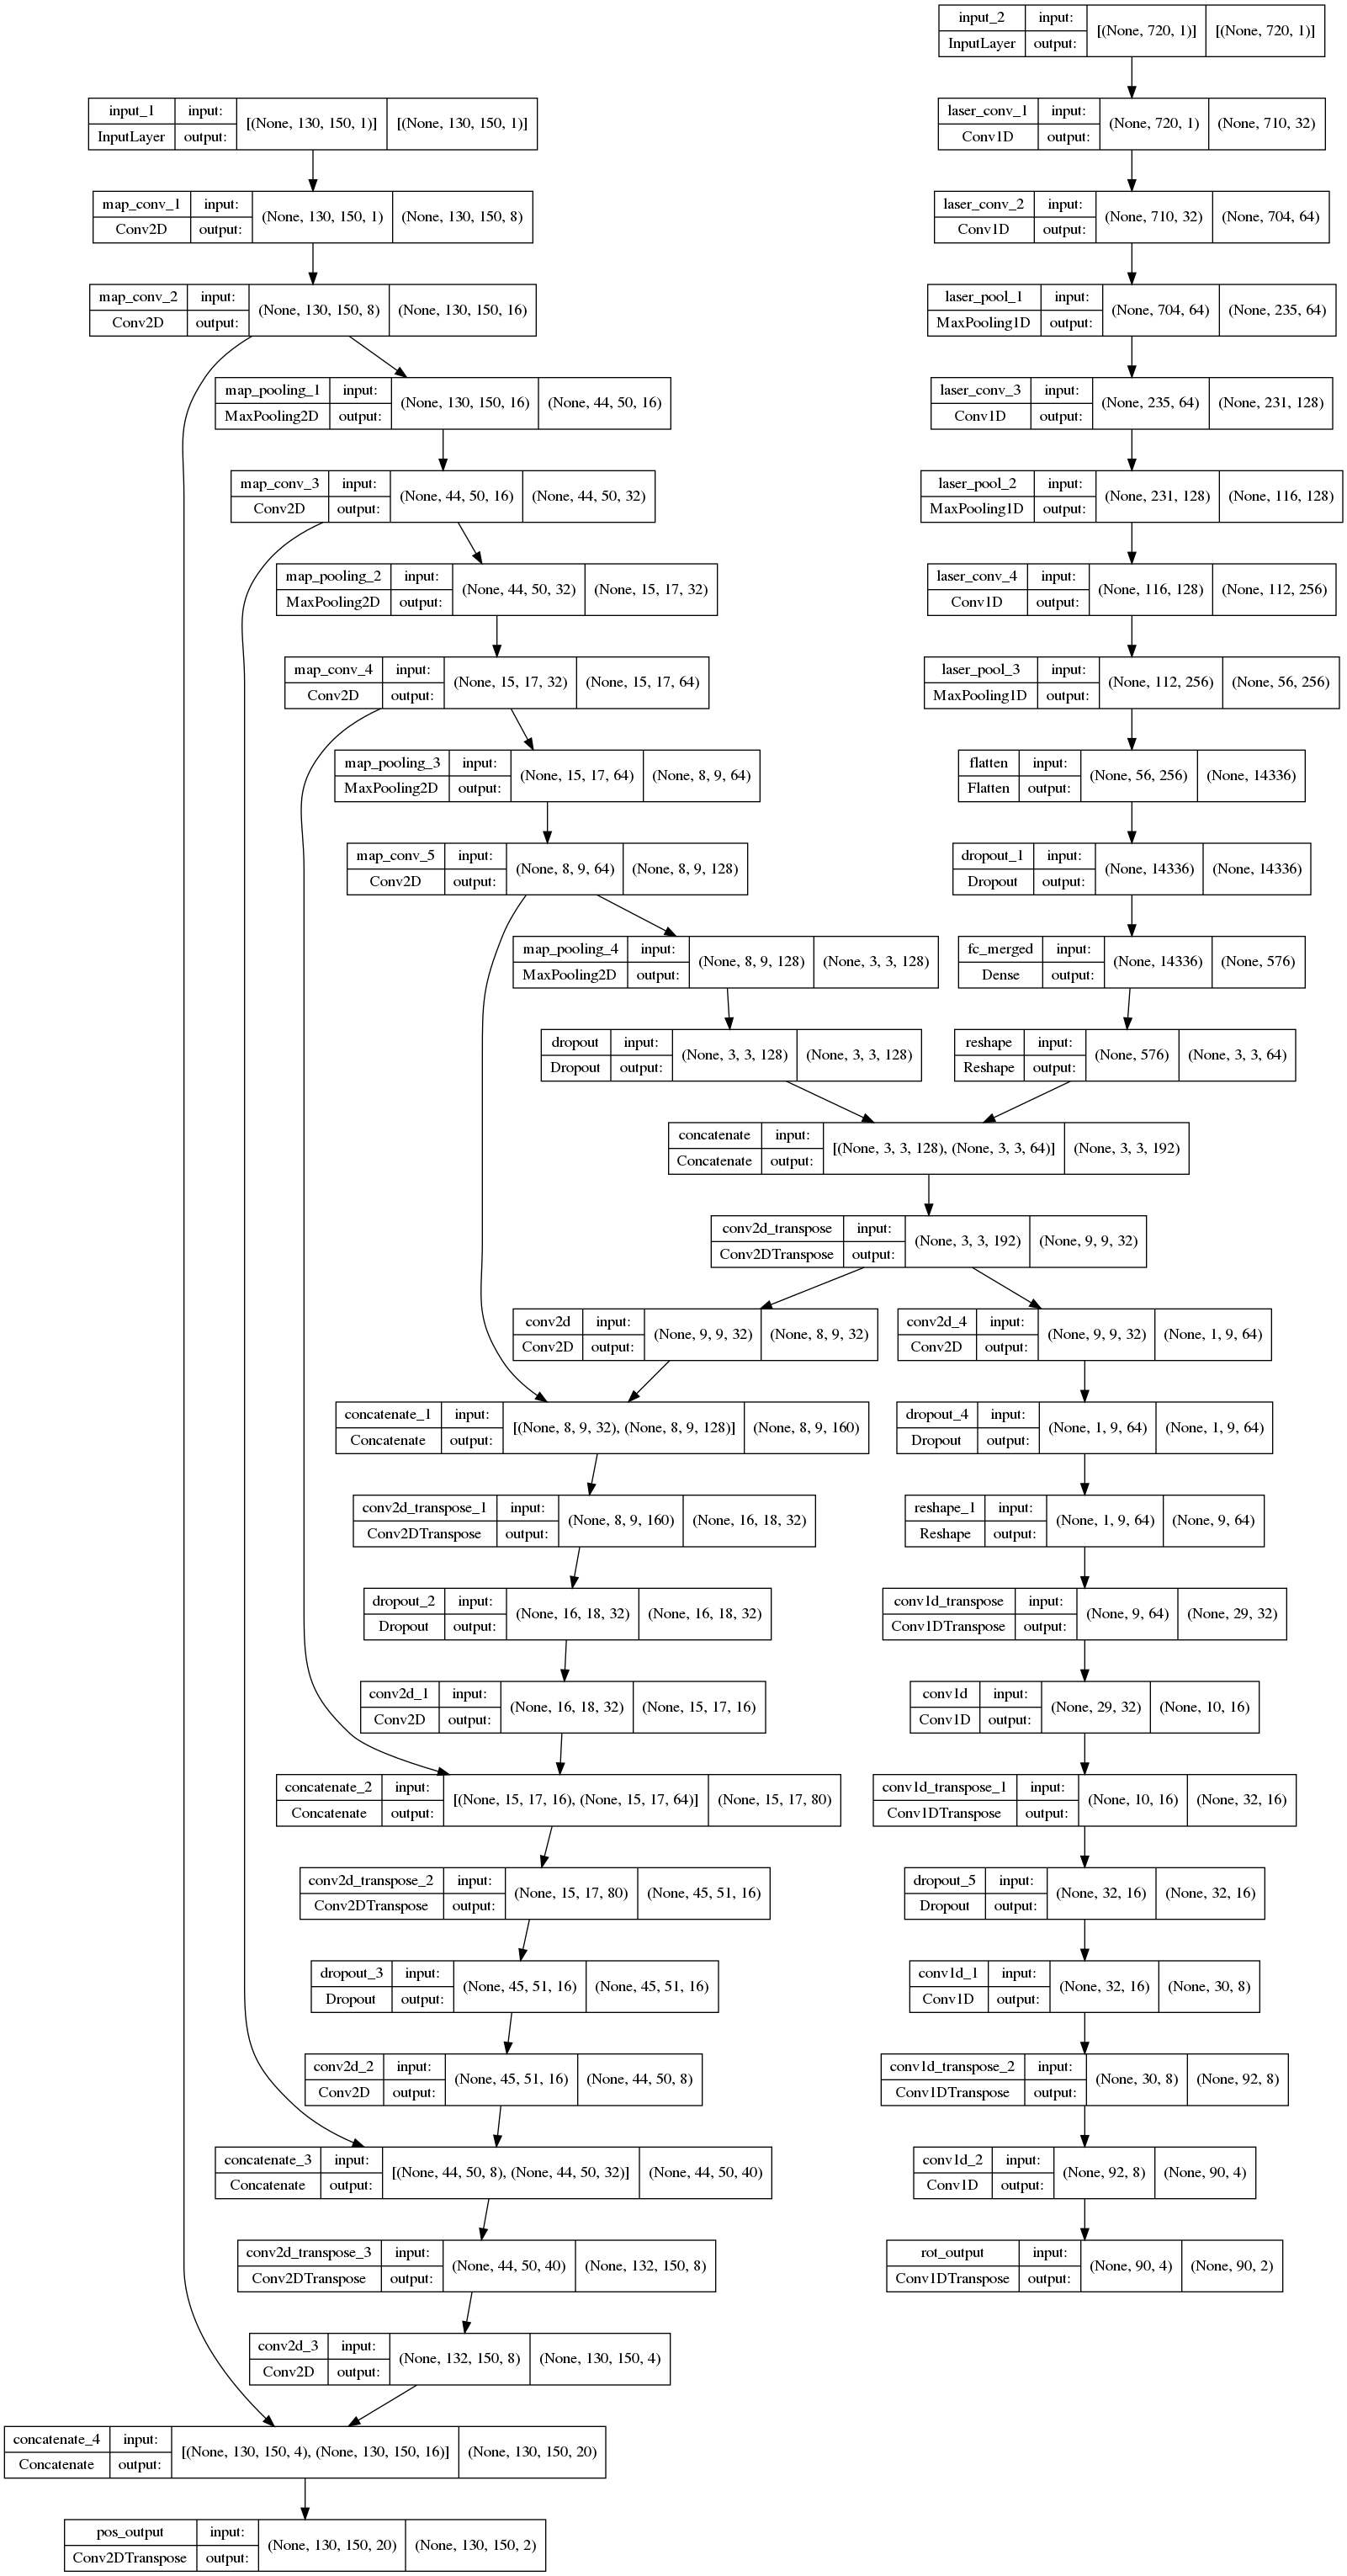

In [6]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 720, 1)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 130, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 laser_conv_1 (Conv1D)          (None, 710, 32)      384         ['input_4[0][0]']                
                                                                                                  
 map_conv_1 (Conv2D)            (None, 130, 150, 8)  976         ['input_3[0][0]']          

In [6]:
model.compile(optimizer = "adam",
    loss=[losses.SparseCategoricalCrossentropy(from_logits=True),losses.SparseCategoricalCrossentropy(from_logits=True)],#losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[None,None]    #["accuracy"]
    )

Data import

In [7]:
data = DAO("datasetaitoff_fp_path720.csv")
data.read()
data.divide_data()

In [8]:
data.TR_features=tf.reshape(data.TR_features,[-1,720,1])
data.TS_features=tf.reshape(data.TS_features,[-1,720,1])
data.TR_targets=tf.reshape(data.TR_targets,[-1,3])
data.TS_targets=tf.reshape(data.TS_targets,[-1,3])

data.TR_targets_pos=tf.gather(data.TR_targets,[0,1],axis=1)
data.TS_targets_pos=tf.gather(data.TS_targets,[0,1],axis=1)
data.TR_targets_rot=tf.gather(data.TR_targets,[2],axis=1)
data.TS_targets_rot=tf.gather(data.TS_targets,[2],axis=1)

In [9]:
TR_map=[]
TS_map=[]

for i in range(data.TR_features.shape[0]):
    TR_map.append(map_img_tensor)

for i in range(data.TS_features.shape[0]):
    TS_map.append(map_img_tensor)

TR_map = tf.reshape(TR_map,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1]])
TS_map = tf.reshape(TS_map,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1]])

In [14]:
from sklearn.model_selection import train_test_split

with open("data/datasetmymap_multirot3_gridpos_r40.csv", "r") as file:
    laser_db_mask = pd.read_csv(file, delimiter=";",header=None).copy()

masks = laser_db_mask.drop(columns=[0])

if len(masks.values) > 2400:
    masks = masks.head(2401)

TR_x, TS_x, TR_masks, TS_masks = train_test_split(data.features, masks, test_size= 0.25, random_state= 42)

TR_masks = tf.reshape(TR_masks,[-1,map_img.shape[0],map_img.shape[1],1])
TS_masks = tf.reshape(TS_masks,[-1,map_img.shape[0],map_img.shape[1],1])

with open("data/datasetmymap_multirot3_gridrot_r3_q90.csv", "r") as file:
    laser_db_mask_rot = pd.read_csv(file, delimiter=";",header=None).copy()

masks_rot = laser_db_mask_rot.drop(columns=[0])

if len(masks_rot.values) > 2400:
    masks_rot = masks_rot.head(2401)

TR_x, TS_x, TR_masks_rot, TS_masks_rot = train_test_split(data.features, masks_rot, test_size= 0.25, random_state= 42)

TR_masks_rot = tf.reshape(TR_masks_rot,[-1,90,1])
TS_masks_rot = tf.reshape(TS_masks_rot,[-1,90,1])

FileNotFoundError: [Errno 2] No such file or directory: 'data/datasetmymap_multirot3_gridpos_r40.csv'

In [10]:
#position grid

TR_masks = []

for i in data.TR_targets_pos.numpy():
    map_grid_inst = pnt_on_grid(map_img_tensor, i,10,pixel_scale)
    TR_masks.append(map_grid_inst)

TS_masks = []

for i in data.TS_targets_pos.numpy():
    map_grid_inst = pnt_on_grid(map_img_tensor, i,10,pixel_scale)
    TS_masks.append(map_grid_inst)

#rotation grid

TR_masks_rot = []

for i in data.TR_targets_rot.numpy():
    rot_grid_inst = quant_rot(i,90, 3)
    TR_masks_rot.append(rot_grid_inst)

TS_masks_rot = []

for i in data.TS_targets_rot.numpy():
    rot_grid_inst = quant_rot(i,90, 3)
    TS_masks_rot.append(rot_grid_inst)

In [11]:
TR_masks = tf.reshape(TR_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
TS_masks = tf.reshape(TS_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])

TR_masks_rot = tf.reshape(TR_masks_rot,[-1,90,1])
TS_masks_rot = tf.reshape(TS_masks_rot,[-1,90,1])

In [45]:
def display(display_list, rot_list):

    subtitle=["True Mask", "Predicted Mask"]

    gs = gridspec.GridSpec(20, 2) 

    fig = plt.figure(figsize=(13,7))

    mask_1 = plt.subplot(gs[:19,0])
    mask_2 = plt.subplot(gs[:19,1])
    rot_1 = plt.subplot(gs[19,0])
    rot_2 = plt.subplot(gs[19,1])

    mask_1.set_title(subtitle[0])
    mask_1.imshow(tf.keras.utils.array_to_img(display_list[0]))
    mask_1.axis("off")
    
    mask_2.set_title(subtitle[1])
    mask_2.imshow(tf.keras.utils.array_to_img(display_list[1]))
    mask_2.axis("off")

    array_rot_1 = rot_list[0]
    array_rot_2 = rot_list[1]

    array_rot_1 = tf.reshape(array_rot_1,[array_rot_1.shape[1],array_rot_1.shape[0],1])
    array_rot_2 = tf.reshape(array_rot_2,[array_rot_2.shape[1],array_rot_2.shape[0],1])

    rot_1.imshow(tf.keras.utils.array_to_img(array_rot_1))
    rot_1.axis("off")

    rot_2.imshow(tf.keras.utils.array_to_img(array_rot_2))
    rot_2.axis("off")

    plt.subplots_adjust(hspace=0)
    plt.show()

def display(display_list):

    subtitle=["True Mask", "Predicted Mask"]

    gs = gridspec.GridSpec(20, 2) 

    fig = plt.figure(figsize=(13,7))

    mask_1 = plt.subplot(gs[:19,0])
    mask_2 = plt.subplot(gs[:19,1])
    #rot_1 = plt.subplot(gs[19,0])
    #rot_2 = plt.subplot(gs[19,1])

    mask_1.set_title(subtitle[0])
    mask_1.imshow(tf.keras.utils.array_to_img(display_list[0]))
    mask_1.axis("off")
    
    mask_2.set_title(subtitle[1])
    mask_2.imshow(tf.keras.utils.array_to_img(display_list[1]))
    mask_2.axis("off")

    #array_rot_1 = rot_list[0]
    #array_rot_2 = rot_list[1]

    #array_rot_1 = tf.reshape(array_rot_1,[array_rot_1.shape[1],array_rot_1.shape[0],1])
    #array_rot_2 = tf.reshape(array_rot_2,[array_rot_2.shape[1],array_rot_2.shape[0],1])

    #rot_1.imshow(tf.keras.utils.array_to_img(array_rot_1))
    #rot_1.axis("off")

    #rot_2.imshow(tf.keras.utils.array_to_img(array_rot_2))
    #rot_2.axis("off")

    plt.subplots_adjust(hspace=0)
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]
    return pred_mask[0]


Model Training

In [46]:
test_map = TS_map[0]
test_x = data.TS_features[0]

test_map = tf.reshape(test_map,[1,map_img.shape[0],map_img.shape[1],1])
test_x = tf.reshape(test_x,[1,720])

pred_test_pos,pred_test_rot = model.predict([test_map,test_x])
sample = create_mask(pred_test_pos)

#pred_test = model.predict([test_map,test_x])
#sample = create_mask(pred_test)

sample_targets = data.TS_targets_pos[0]

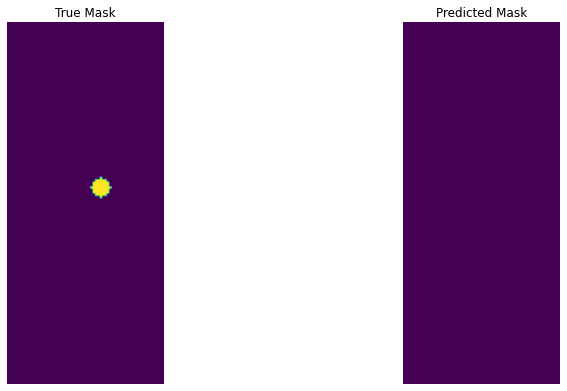

In [47]:
display([TS_masks[0],sample])

In [12]:
from IPython.display import clear_output

class MyCallback(tf.keras.callbacks.Callback):
    min_loss=10

    #test_map = TS_map[0]
    #test_x = TS_x.values[0]

    #test_map = tf.reshape(test_map,[1,map_img.shape[0],map_img.shape[1],1])
    #test_x = tf.reshape(test_x,[1,720])

    def on_epoch_end(self, epoch, logs=False):
        
        if logs["val_loss"]<self.min_loss and logs["val_loss"]<logs["loss"]:
            model.save_weights("models/LM_cp-epoch-train.ckpt")
            self.min_loss = logs["val_loss"]
        
        #if epoch % 5 == 4:
            clear_output(wait=True)

my_callback= MyCallback()

In [ ]:
history = model.fit([TR_map,data.TR_features],
    data.TR_targets_pos,#[data.TR_targets_pos, data.TR_targets_rot], 
    validation_data=([TS_map,data.TS_features],data.TS_targets_pos),#[data.TS_targets_pos,data.TS_targets_rot]), 
    verbose=1,
    batch_size=16,
    epochs=300,
    callbacks=[my_callback]
    )

In [13]:
history = model.fit([TR_map,data.TR_features],
    [TR_masks, TR_masks_rot], #TR_masks,
    validation_data=([TS_map,data.TS_features],[TS_masks,TS_masks_rot]), #TS_masks),
    verbose=1,
    batch_size=16,
    epochs=200,
    callbacks=[my_callback]
    )

113/113 [==============================] - 12s 103ms/step - loss: 0.0512 - pos_output_loss: 0.0113 - rot_output_loss: 0.0399 - val_loss: 0.0485 - val_pos_output_loss: 0.0124 - val_rot_output_loss: 0.0362
Epoch 31/200
113/113 [==============================] - 11s 95ms/step - loss: 0.0510 - pos_output_loss: 0.0112 - rot_output_loss: 0.0397 - val_loss: 0.0623 - val_pos_output_loss: 0.0181 - val_rot_output_loss: 0.0442
Epoch 32/200
113/113 [==============================] - 10s 92ms/step - loss: 0.0505 - pos_output_loss: 0.0112 - rot_output_loss: 0.0393 - val_loss: 0.0666 - val_pos_output_loss: 0.0285 - val_rot_output_loss: 0.0381
Epoch 33/200
113/113 [==============================] - 10s 93ms/step - loss: 0.0471 - pos_output_loss: 0.0108 - rot_output_loss: 0.0363 - val_loss: 0.0550 - val_pos_output_loss: 0.0164 - val_rot_output_loss: 0.0387
Epoch 34/200
113/113 [==============================] - 10s 92ms/step - loss: 0.0473 - pos_output_loss: 0.0109 - rot_output_loss: 0.0363 - val_loss:

In [ ]:
my_callback.min_loss

0.9462989568710327

In [16]:
my_callback.min_loss

0.9050723314285278

Evaluation best model

In [5]:
model = model_define(map_img_tensor, laser_inst, 90)

model.load_weights("models/LM_cp-epoch-train.ckpt")

In [6]:
data = DAO("datasetaitoff_path720.csv")
data.read()

data.features=tf.reshape(data.features,[-1,720,1])
data.targets=tf.reshape(data.targets,[-1,3])

data.TS_targets_pos=tf.gather(data.targets,[0,1],axis=1)
data.TS_targets_rot=tf.gather(data.targets,[2],axis=1)

map_masks=[]

for i in range(data.features.shape[0]):
    map_masks.append(map_img_tensor)

map_masks = tf.reshape(map_masks,[-1,map_img_tensor.shape[0],map_img_tensor.shape[1]])

In [16]:
#error centroids pos

pos_array = []

for index in range(len(map_masks)):

    test_map = map_masks[index]
    test_x = data.features.numpy()[index]

    test_map = tf.reshape(test_map,[1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
    test_x = tf.reshape(test_x,[1,720])

    pred_test_pos,pred_test_rot = model.predict([test_map,test_x])
    pred_test_pos = tf.reshape(pred_test_pos,[pred_test_pos.shape[1],pred_test_pos.shape[2],2])

    list_fp_pred = list_from_fingerprint(pred_test_pos,pixel_scale)

    if len(list_fp_pred) > 0:
        centroid_pred = get_pos_from_list_fp(list_fp_pred)

    else:
        centroid_pred = [-1,-1]

    pos_array.append(centroid_pred)

    print(index)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
#error centroids rot

rot_array = []

for index in range(len(map_masks)):

    test_map = map_masks[index]
    test_x = data.features.numpy()[index]

    test_map = tf.reshape(test_map,[1,map_img_tensor.shape[0],map_img_tensor.shape[1],1])
    test_x = tf.reshape(test_x,[1,720])

    pred_test_pos,pred_test_rot = model.predict([test_map,test_x])
    pred_test_rot = tf.reshape(pred_test_rot,[pred_test_rot.shape[1],2])

    list_slice = list_from_rotation(pred_test_rot)

    if len(list_slice) > 0:
        orientation = np.radians(get_rot_from_slice(list_slice,pred_test_rot.shape[0]))

    else:
        orientation = -1

    rot_array.append(orientation)
    
    print(index)

2022-08-31 14:09:39.152747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
with open('metrics/LM_estimate.csv', 'w') as f:
    for i in range(len(pos_array)):
        f.write("{};{};{};{}\n".format(i,pos_array[i][0],pos_array[i][1],rot_array[i]))

In [8]:
with open('metrics/LM_estimate_rot.csv', 'w') as f:
    for i in range(len(rot_array)):
        f.write("{};{}\n".format(i,rot_array[i]))

Multi direction

In [8]:
def evaluate(model, data_tensor, TR_map):
    result = model.predict([TR_map, data_tensor.features])
    
    pos_test = result[0]
    rot_test = result[1][:,0]
    pos_real = np.array([data_eval.TS_targets_pos.numpy()[:,0],data_eval.TS_targets_pos.numpy()[:,1]]).T
    rot_real = data_eval.TS_targets_rot.numpy()[:,0]

    return pos_test, rot_test, pos_real, rot_real

In [9]:
def get_data(filename,map_img):
    data_test = DAO(filename)

    data_test.read()

    data_tensor_test=DAO()

    data_tensor_test.features=tf.reshape(data_test.features,[-1,720,1])
    data_tensor_test.targets=tf.reshape(data_test.targets,[-1,3])

    data_tensor_test.TS_targets_pos=tf.gather(data_test.targets,[0,1],axis=1)
    data_tensor_test.TS_targets_rot=tf.gather(data_test.targets,[2],axis=1)

    TR_map=[]

    for i in range(data_tensor_test.features.shape[0]):
        TR_map.append(map_img)

    TR_map = tf.reshape(TR_map,[-1,map_img.shape[0],map_img.shape[1]])

    return data_tensor_test, TR_map


In [8]:
#data_eval, map_eval = get_data("laser_log2203.csv",map_img)

#pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

#with open('predict_data2203.csv', 'w') as f:
#    for i in range(len(pos_real)):
#        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


data_eval, map_eval = get_data("laser_log2303.csv",map_img)

pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

with open('predict_data2303.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


2022-04-26 15:31:45.620114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-04-26 15:31:46.451828: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 822.20MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [10]:
data_eval, map_eval = get_data("datasetmymap(3-123,60-64).csv",map_img)

pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

with open('predict_datasetmymap(3-123,60-64).csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


2022-04-27 16:30:45.977861: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


Uni direction

In [6]:
def evaluate(model, data_tensor, TR_map):
    result = model.predict([TR_map, data_tensor.features])
    
    pos_test = result
    pos_real = np.array([data_eval.TS_targets_pos.numpy()[:,0],data_eval.TS_targets_pos.numpy()[:,1]]).T

    return pos_test, pos_real

In [7]:
def get_data(filename,map_img):
    data_test = DAO(filename)

    data_test.read()

    data_tensor_test=DAO()

    data_tensor_test.features=tf.reshape(data_test.features,[-1,720,1])
    data_tensor_test.targets=tf.reshape(data_test.targets,[-1,3])

    data_tensor_test.TS_targets_pos=tf.gather(data_test.targets,[0,1],axis=1)
    data_tensor_test.TS_targets_rot=tf.gather(data_test.targets,[2],axis=1)

    TR_map=[]

    for i in range(data_tensor_test.features.shape[0]):
        TR_map.append(map_img)

    TR_map = tf.reshape(TR_map,[-1,map_img.shape[0],map_img.shape[1]])

    return data_tensor_test, TR_map


In [16]:
data_eval, map_eval = get_data("laser_log2303_unidir.csv",map_img)

pos_test, pos_real = evaluate(model, data_eval, map_eval)

with open('predict_data2303_unidir.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],pos_test[i][0],pos_test[i][1]))

KeyboardInterrupt: 

In [8]:
data_eval, map_eval = get_data("datasetmymap(3-123,60-64)_unidir.csv",map_img)

pos_test, pos_real = evaluate(model, data_eval, map_eval)

with open('predict_datasetmymap.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],pos_test[i][0],pos_test[i][1]))


2022-05-02 16:23:57.652676: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
